In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Black and White to Color Data

In [2]:
import multiprocessing
from fastai.conv_learner import *
from pathlib import Path
from itertools import repeat
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
PATH_TRN = PATH/'train'

In [4]:
sz = 128

In [5]:
train_resized = PATH/('train_' + str(sz))

In [6]:
train_resized_bw = PATH/('train_' + str(sz) + '_bw')

In [80]:
def generate_full_path(rootpath: Path, relativepath: Path):
    return rootpath/relativepath

In [7]:
def generate_dest_path(sourceroot: Path, sourcepath: Path, destroot: Path):
    relativepath = sourcepath.relative_to(sourceroot)
    destpath = generate_full_path(destroot, relativepath)
    return destpath

In [8]:
def dest_path_generator(sourceroot: Path, raw_sourcepaths: [Path], destroot: Path):
    return (generate_dest_path(sourceroot=sourceroot, sourcepath=generate_full_path(sourceroot.parent, Path(raw_sourcepath)), destroot=destroot) 
            for raw_sourcepath in raw_sourcepaths)

In [9]:
def generate_folders_for_dest(destpaths: [Path]):
    destdirs = set(destpath.parent for destpath in destpaths)
    
    for destdir in destdirs:
        destdir.mkdir(parents=True, exist_ok=True)
    

In [10]:
def transform_image_and_save_new(function, sourcepath: Path, destpath: Path):
    try:
        with Image.open(sourcepath) as image:
            image = function(image)
            image.save(destpath)
    except Exception as ex:
        print(ex)
    

In [14]:
def transform_images_to_new_directory(function, sourceroot: Path, destroot: Path):
    destroot.mkdir(exist_ok=True)
    raw_sourcepaths, _, _ = folder_source(sourceroot.parent, sourceroot.name)
    #First make the destination directories if they don't already exist- we want the subsequent operations to be threadsafe.  Then create
    #another generator of destpaths for use in the image generation
    generate_folders_for_dest(destpaths=dest_path_generator(sourceroot=sourceroot, raw_sourcepaths=raw_sourcepaths, destroot=destroot))   
    destpaths = dest_path_generator(sourceroot=sourceroot, raw_sourcepaths=raw_sourcepaths, destroot=destroot)
    sourcepaths = (sourceroot.parent/Path(raw_sourcepath) for raw_sourcepath in raw_sourcepaths)
    numthreads = multiprocessing.cpu_count()
    
    with ThreadPoolExecutor(numthreads) as e:
        try:
            e.map(partial(transform_image_and_save_new, function), sourcepaths, destpaths)
        except Exception as ex:
            print(ex)

## Resize Images

In [15]:
def resize_image(image: Image, size: int):
    return image.resize((size,size))

In [16]:
transform_images_to_new_directory(partial(resize_image, size=sz), PATH_TRN, train_resized)

/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 39976960 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/f

cannot write mode RGBA as JPEG


/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/jason/anaconda3/envs/fasta

## Generate Black and White Versions of Images

In [17]:
def to_grayscale_image(image: Image):
    return image.convert('L')

In [18]:
transform_images_to_new_directory(to_grayscale_image, train_resized, train_resized_bw)

cannot identify image file '/media/jason/Projects/Deep Learning/data/imagenet/ILSVRC/Data/CLS-LOC/train_128/n02105855/n02105855_2933.JPEG'


## Get Usable Images List

In [107]:
def get_matched_xy_image_lists(x_root_path: Path, y_root_path: Path):
    fnames_full_x,_,_ = folder_source(x_root_path.parent, x_root_path.name)
    x_relative_paths_raw = [Path(*Path(fn).parts[1:]) for fn in fnames_full_x]
    
    fnames_full_y,_,_ = folder_source(y_root_path.parent, y_root_path.name)
    y_relative_paths_raw = [Path(*Path(fn).parts[1:]) for fn in fnames_full_y]
    
    x_relative_paths, y_relative_paths = filter_unmatched_images(x_relative_paths = x_relative_paths_raw, y_relative_paths = y_relative_paths_raw)
    
    x_paths = [Path(*x_root_path.parts[-1:])/relative_path for relative_path in x_relative_paths]
    y_paths = [Path(*y_root_path.parts[-1:])/relative_path for relative_path in y_relative_paths]
    
    x_paths.sort()
    y_paths.sort()
    
    return (x_paths, y_paths)
    

In [108]:
def filter_unmatched_images(x_relative_paths: [Path], y_relative_paths: [Path]):
    x_paths_set = set(x_relative_paths)
    y_paths_set = set(y_relative_paths)
    
    for x_path in x_relative_paths:
        if x_path not in y_paths_set and x_path in x_paths_set:
            x_paths_set.remove(x_path)
    
    for y_path in y_relative_paths:
        if y_path not in x_paths_set and y_path in y_paths_set:
            y_paths_set.remove(y_path)
            
    return (list(x_paths_set), list(y_paths_set))
            
    

In [109]:
def convert_paths_to_str(paths: [Path]):
    return [str(path) for path in paths]

In [110]:
x_paths, y_paths = get_matched_xy_image_lists(x_root_path=train_resized_bw, y_root_path=train_resized)

In [111]:
x_paths[:5]

[PosixPath('train_128_bw/n01440764/n01440764_10026.JPEG'),
 PosixPath('train_128_bw/n01440764/n01440764_10027.JPEG'),
 PosixPath('train_128_bw/n01440764/n01440764_10029.JPEG'),
 PosixPath('train_128_bw/n01440764/n01440764_10040.JPEG'),
 PosixPath('train_128_bw/n01440764/n01440764_10042.JPEG')]

In [112]:
y_paths[:5]

[PosixPath('train_128/n01440764/n01440764_10026.JPEG'),
 PosixPath('train_128/n01440764/n01440764_10027.JPEG'),
 PosixPath('train_128/n01440764/n01440764_10029.JPEG'),
 PosixPath('train_128/n01440764/n01440764_10040.JPEG'),
 PosixPath('train_128/n01440764/n01440764_10042.JPEG')]

In [113]:
x_paths_str = convert_paths_to_str(x_paths)

In [114]:
x_paths_str = convert_paths_to_str(x_paths)
x_paths_str[:5]

['train_128_bw/n01440764/n01440764_10026.JPEG',
 'train_128_bw/n01440764/n01440764_10027.JPEG',
 'train_128_bw/n01440764/n01440764_10029.JPEG',
 'train_128_bw/n01440764/n01440764_10040.JPEG',
 'train_128_bw/n01440764/n01440764_10042.JPEG']

In [115]:
y_paths_str = convert_paths_to_str(y_paths)
y_paths_str[:5]

['train_128/n01440764/n01440764_10026.JPEG',
 'train_128/n01440764/n01440764_10027.JPEG',
 'train_128/n01440764/n01440764_10029.JPEG',
 'train_128/n01440764/n01440764_10040.JPEG',
 'train_128/n01440764/n01440764_10042.JPEG']

## Model

In [116]:
bs = 64
np.random.seed(42)
#keep_pct = 1.
keep_pct = 0.02
keeps = np.random.rand(len(x_paths_str)) < keep_pct
fnames_x = np.array(x_paths_str, copy=False)[keeps]
fnames_y = np.array(y_paths_str, copy=False)[keeps]

In [117]:
arch = vgg16

In [118]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [119]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

In [120]:
val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
len(val_x),len(trn_x)

(2558, 23026)

In [121]:
img_fn = train_resized_bw/'n01558993'/'n01558993_9684.JPEG'

In [122]:
tfms = tfms_from_model(arch, sz, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=train_resized_bw.parent)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [123]:
denorm = md.val_ds.denorm

In [124]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [125]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

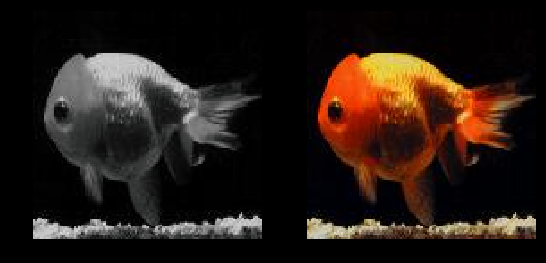

In [126]:
idx=1
fig,axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1])

In [127]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

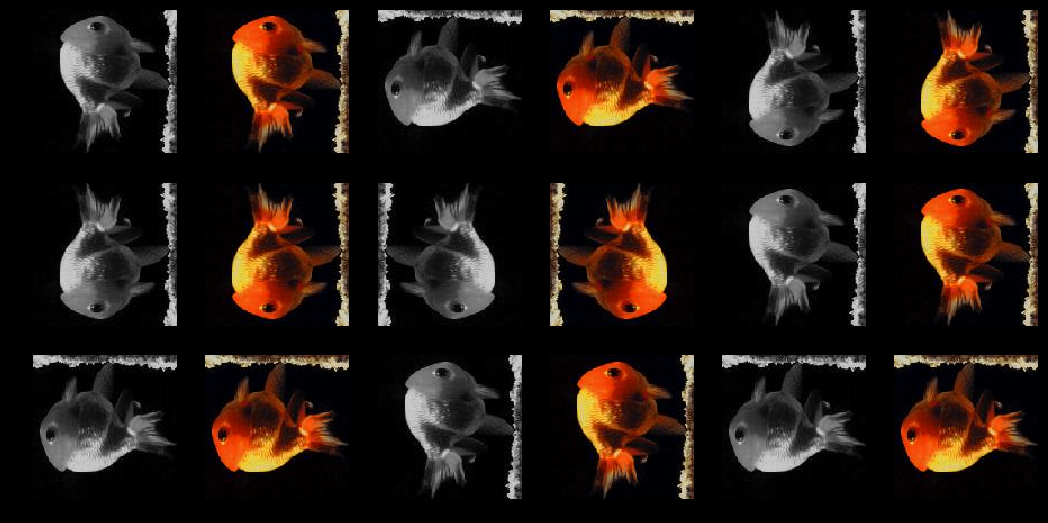

In [128]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_img(x,idx, ax=axes.flat[i*2])
    show_img(y,idx, ax=axes.flat[i*2+1])

## Model

In [142]:
def conv(ni, nf, kernel_size=3):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    layers.append(nn.ReLU(True))
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [143]:
class ResSequential(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.m = nn.Sequential(*layers)

    def forward(self, x): 
        return x + self.m(x)

In [144]:
def res_block(nf):
    return ResSequential([conv(nf, nf), conv(nf, nf)])

In [164]:
class SrResnet(nn.Module):
    def __init__(self, nf):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): 
            features.append(res_block(64))
        
        features += [conv(64, 3)]
        
        self.features = nn.Sequential(*features)
        
    def forward(self, x): 
        return self.features(x)

## Perceptual loss

In [165]:
m_vgg = vgg16(True)

blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [166]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [167]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [168]:
def flatten(x): return x.view(x.size(0), -1)

In [169]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [170]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [242]:
m = SrResnet(64)

In [243]:
m = to_gpu(m)

In [244]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [245]:
m = nn.DataParallel(m, [0,1,2,3])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [246]:
learn.set_data(md)

In [247]:
#learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1]) (turns sepia)
#learn.crit = F.mse_loss (turns sepia)
#learn.crit = F.l1_loss (turns it into a totally blank sepia image!)
learn.crit =  FeatureLoss(m_vgg, blocks[:3], [0.9,0.05,0.05])

In [248]:
wd=1e-7

In [249]:
learn.lr_find(1e-4, 0.1, wds=wd, linear=False)

epoch      trn_loss   val_loss   
    0      0.128024   0.134661  


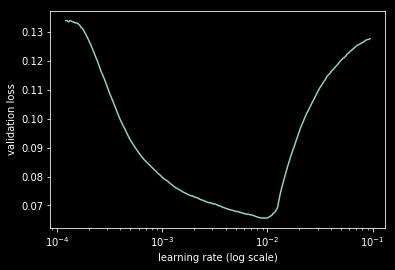

In [250]:
learn.sched.plot(n_skip_end=1)

In [251]:
lr=9e-3

In [252]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   
    0      0.076106   0.074543  
    1      0.072552   0.072174  


[array([0.07217])]

In [253]:
learn.save('bwtoc0')

In [254]:
learn.load('bwtoc0')

In [255]:
def plot_ds_img(idx, ax=None, figsize=(7,7), normed=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    im = md.val_ds[idx][0]
    if normed: im = denorm(im)[0]
    else:      im = np.rollaxis(to_np(im),0,3)
    ax.imshow(im)
    ax.axis('off')

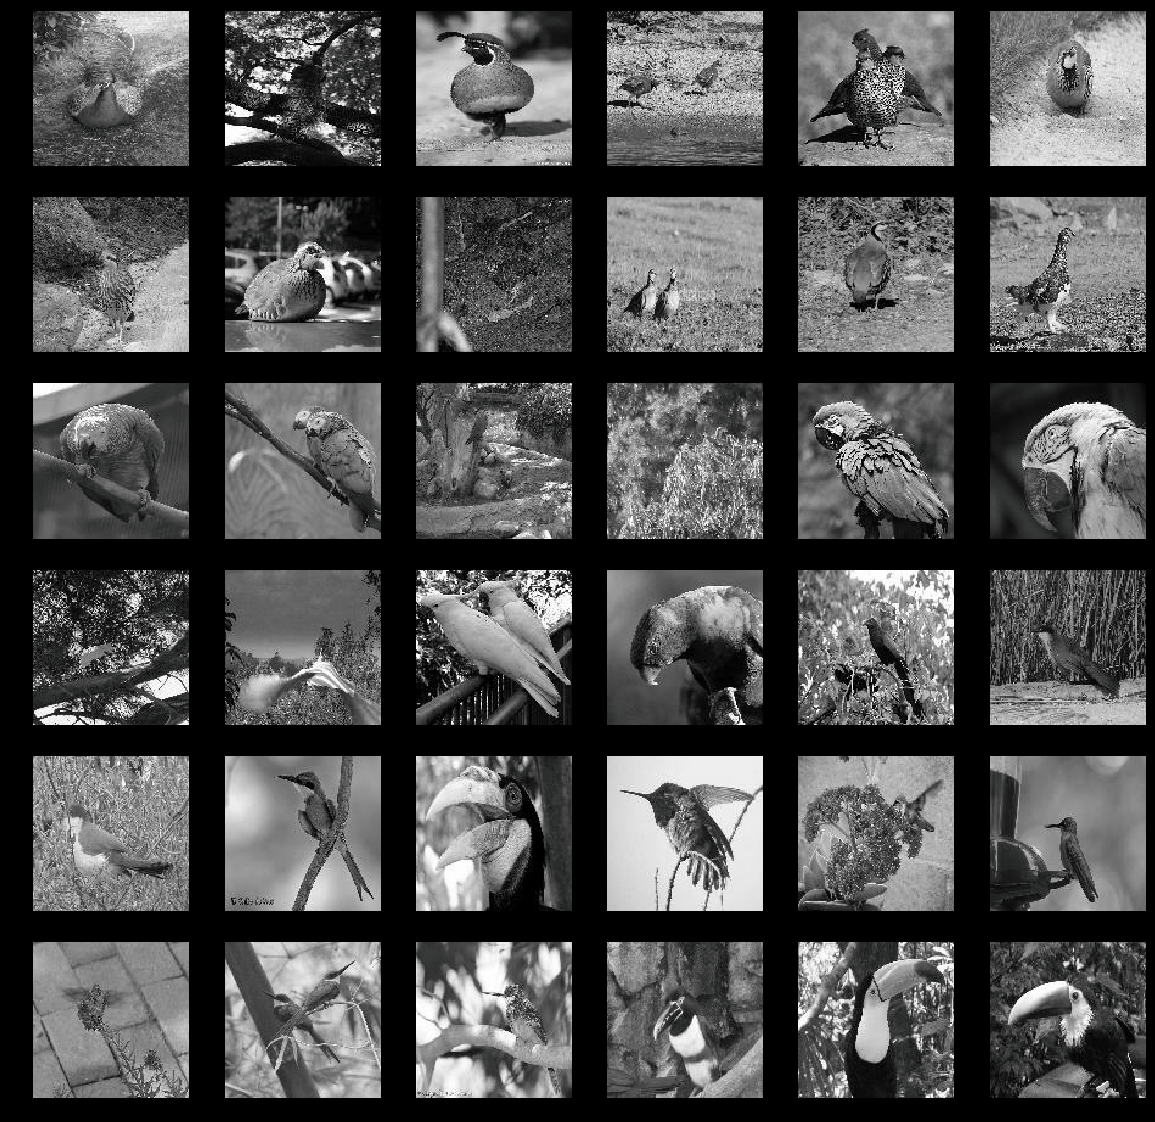

In [256]:
fig,axes=plt.subplots(6,6,figsize=(20,20))
for i,ax in enumerate(axes.flat): plot_ds_img(i+200,ax=ax, normed=True)

In [273]:
x,y=md.val_ds[213]

In [274]:
y=y[None]

In [275]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape,y.shape,preds.shape

((3, 128, 128), (1, 3, 128, 128), torch.Size([1, 3, 128, 128]))

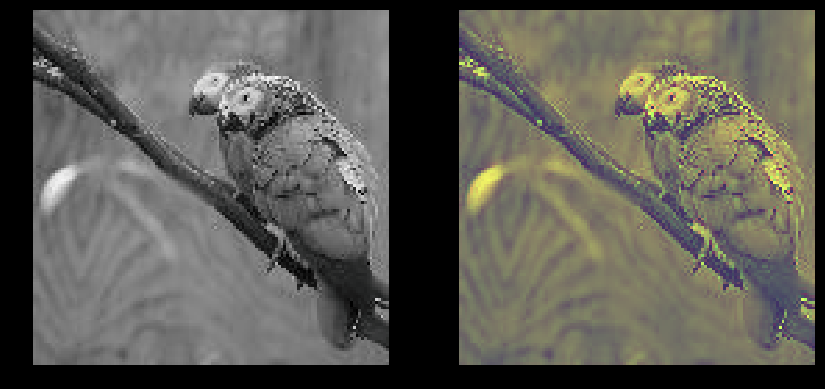

In [276]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

In [198]:
lr=lr/2

In [199]:
learn.fit(lr, 1, cycle_len=1, wds=wd, use_clr_beta=(20,10,0.95,0.85))

 86%|████████▌ | 309/360 [01:39<00:16,  3.12it/s, loss=0.0317]

KeyboardInterrupt: 

In [ ]:
learn.save('bwtoc1')

In [ ]:
learn.load('bwtoc1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lr/3, 1, cycle_len=1, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc2')

In [ ]:
learn.load('bwtoc2')

In [ ]:
learn.sched.plot_loss()

In [ ]:
fig,axes=plt.subplots(6,6,figsize=(20,20))
for i,ax in enumerate(axes.flat): plot_ds_img(i+200,ax=ax, normed=True)

In [ ]:
x,y=md.val_ds[211]

In [ ]:
y=y[None]

In [ ]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape,y.shape,preds.shape

In [ ]:
learn.crit(preds, V(y), sum_layers=False)

In [ ]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

In [ ]:
bs = 32
sz = 256

In [ ]:
t = torch.load(learn.get_model_path('bwtoc2'), map_location=lambda storage, loc: storage)
learn.model.load_state_dict(t, strict=False)

In [ ]:
learn.freeze_to(999)

In [ ]:
for i in range(10,13): set_trainable(learn.model.module.features[i], True)

In [ ]:
conv_shuffle = learn.model.module.features[10][2][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [ ]:
lr=6e-3
wd=1e-7

In [ ]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc3')

In [ ]:
learn.load('bwtoc3')

In [ ]:
learn.fit(lr/2, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc4')

In [ ]:
learn.load('bwtoc4')

In [ ]:
learn.fit(lr/6, 1, cycle_len=1, wds=wd, use_clr=(20,10))

In [ ]:
learn.save('bwtoc5')

In [ ]:
learn.load('bwtoc5')

In [ ]:
train_tfms,val_tfms = tfms_from_model(arch, sz)

In [ ]:
image_root = 'data/style/'
image_name = 'csi_enhance'
img_fn = f'{image_root}{image_name}.jpg'
img = open_image(img_fn)
img_tfm = val_tfms(img)
preds = learn.model(VV(img_tfm[None]))

In [ ]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(img_tfm[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])